# Sweep U Values

In [104]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy import sin
from numpy import pi
import matplotlib as mpl
from scipy.stats import linregress
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=20

In [105]:
L=1
J1=0.1
J2=1
J_m=np.max([abs(J1), abs(J2)])
ω=10
N=20
weight=0.01

En estos subalgoritmos definimos los operadores creación y destrucción de bosones:
$$a |n\rangle = \sqrt{n} |n-1\rangle \qquad a^\dagger |n \rangle = \sqrt{n+1} |n+1  \rangle$$

In [106]:
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a(n):
    if n == 0:
        return (0,0)
    else:
        return (n-1, np.sqrt(n))

@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a_plus(n):
    return (n+1, np.sqrt(n+1))

In [107]:
#Definimos el producto entre un bra y un ket, si son iguales vale 1 y si son distintos 0
@numba.jit(float64(float64[:],float64[:]), nopython = True, parallel = False)
def bracket(bra1, ket1):
    if np.all(bra1 == ket1):
        return 1
    else:
        return 0

In [108]:
n_eigval=int(N*(N+1)/2)
if ω==0:
    ω_array=2*weight*(np.random.rand(N)-0.5)
else:
    ω_array=ω*(1+2*weight*(np.random.rand(N)-0.5))
ω_matrix=np.zeros((n_eigval, n_eigval))
counter=0
for l in range(N):
    for k in range(l,N):
        ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
        counter+=1

In [109]:
#Este subalgoritmo calcula un elemento de matriz con un Hamiltoniano 
@numba.jit(float64(float64[:],float64[:],float64, int64, int64, int64), nopython = True, parallel = False)
def Elemento_matriz_Hamiltoniano(bra, ket, U, N, i, j):
    #<bra|H|ket>
    #Inicialización
    n_eigval=N*(N+1)/2
    H=0
    ket_aux = np.empty(len(ket))
    ket_aux2 = np.empty(len(ket))
    bra_aux = np.empty(len(ket))
    #Términos en N y en N(N-1) del Hamiltoniano
    bracket1 = bracket(bra, ket)
    H += np.sum(ω_matrix[i, j]*ket*bracket1)
    H += np.sum(0.5*U*ket*(ket-1)*bracket1)
    
    ket_aux[:] = ket
    ket_aux2[:] = ket
    bra_aux[:] = bra
    #Calculamos los extremos de la cadena
    if (N-1)%2==0:
        J=-J1
    else:
        J=-J2
    ket_aux[0], coef_term2=0,0
    ket_aux[N-1], coef_term2_aux=a_plus(ket_aux[N-1])
    term2 = J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
    ket_aux2[N-1], coef_term3=a(ket_aux2[N-1])
    #P.B.C.
    #ket_aux2[0], coef_term3_aux=a_plus(ket_aux2[0])
    #H.B.C.
    ket_aux2[0], coef_term3_aux=0,0
    term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
    H+=term2+term3
    for i in range(len(ket)-1):
            #Recorremos el resto de sitios de la cadena
            ket_aux[:] = ket
            ket_aux2[:] = ket
            bra_aux[:] = bra
            if i%2==0:
                J=-J1
            else:
                J=-J2
            ket_aux[i+1], coef_term2 = a(ket_aux[i+1])
            ket_aux[i], coef_term2_aux=a_plus(ket_aux[i])
            term2=J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
            ket_aux2[i], coef_term3=a(ket_aux2[i])
            ket_aux2[i+1], coef_term3_aux=a_plus(ket_aux2[i+1])
            term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
            H+=term2+term3
    return H

In [110]:
@numba.jit(float64[:,:](float64,float64[:,:], int64), nopython = True, parallel = False)
def ComputeH(U,base, N):
    n_eigval=int(N*(N+1)/2)
    H = np.empty((n_eigval,n_eigval))
    for i2 in range(n_eigval):
        for j2 in range(n_eigval):
            H[i2,j2]=Elemento_matriz_Hamiltoniano(base[i2],base[j2], U, N, i2, j2)
    return H

In [111]:
@numba.jit(float64[:, :](int64, float64, float64, float64), nopython=True, parallel=False)
def FastHamiltonian(N, J1, J2, Δ):
    #Manera rapida de calcular el Hamiltoniano de 1 particula
    aux_N=int(N/2) #Numero de celdas
    H_int1=np.asarray([[0, 1], [1, 0]])
    aux1=np.kron(np.eye(aux_N), H_int1)
    aux2=np.eye(N, k=1)+np.eye(N, k=-1)-aux1
    H=J1*aux1+J2*aux2+ω*np.eye(N)
    return H

In [112]:
@numba.jit(numba.types.Tuple((int64[:], int64[:], int64[:], float64[:]))(int64), nopython = True, parallel = False)
def ComputeIndexes(N):    
    H1p=FastHamiltonian(N, J1, J2, 0)
    eigval1p, eigvect1p=eig(H1p)
    idx1p = np.argsort(eigval1p)
    eigval1p = eigval1p[idx1p]
    eigvalNeg=eigval1p[:int(N/2)]
    if J2>J1:
        InterestingIndex=np.argmax(eigvalNeg)
    else:
        InterestingIndex=-100
    E_teorIndep=[]
    NumberIterations=0
    IndexEdgeEdge=[]
    IndexBulkEdge=[]
    counter=0
    #Edge_Edge_Energies=[2*eigval1p[InterestingIndex], eigval1p[InterestingIndex]+ eigval1p[InterestingIndex+1], 2*eigval1p[InterestingIndex+1]]
    for i in range(N):
        for j in range (i,N):
            E_teorIndep.append(eigval1p[i]+eigval1p[j])
            if i== InterestingIndex or i==InterestingIndex+1:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexEdgeEdge.append(counter)
                else:
                    IndexBulkEdge.append(counter)
            else:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexBulkEdge.append(counter)
            counter+=1
    E_teorIndep=np.asarray(E_teorIndep)
    idx=np.argsort(E_teorIndep)
    E_teorIndep=E_teorIndep[idx]
    for i in range(len(IndexEdgeEdge)):
        IndexEdgeEdge[i]=np.argmin(np.abs(idx-IndexEdgeEdge[i]))
    for i in range(len(IndexBulkEdge)):
        IndexBulkEdge[i]=np.argmin(np.abs(idx-IndexBulkEdge[i]))
    IndexBulkBulk=[]
    for k in range(len(E_teorIndep)):
        if k in IndexBulkEdge :
            dummy=1
        elif k in IndexEdgeEdge:
            dummy=2
        else:
            IndexBulkBulk.append(k)
    IndexEdgeEdge=np.asarray(IndexEdgeEdge)
    IndexBulkEdge=np.asarray(IndexBulkEdge)
    IndexBulkBulk=np.asarray(IndexBulkBulk)
    #print(IndexBulkBulk, IndexBulkEdge, IndexEdgeEdge)
    #print(out)
    return (IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep)
#ComputeIndexes(10)

In [113]:
@numba.jit(numba.types.Tuple((float64[:], float64[:], complex128[:], complex128[:]))(float64[:,:]), nopython = True, parallel = False)
def ComputeEigvalMinMax(H):
    #H=Matrix(n_eigval, n_eigval, func_aux)
    #display(H)
    #H=np.array(H).astype(np.float64)
    #eigval, eigvect = np.linalg.eig(H)
    eigval, eigvect = eig(H.astype(complex128))
    eigval=eigval.real
    idx = np.argsort(eigval)
    eigval =eigval[idx]
    eigvect = eigvect[:,idx]
    participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
    Order=np.argsort(participation_ratio[int(N*(N+1)/2-20):int(N*(N+1)/2)])
    return (eigval, participation_ratio, eigvect[Order[0]], eigvect[Order[1]])


@numba.jit(float64[:,:,:](float64,float64,int64,float64[:,:], int64), nopython = True, parallel = True)
def sweepUSubalg(U_min, U_max, U_points, base, N):
    n_eigval=int(N*(N+1)/2)
    MinPRvsUHyperMatrix = np.zeros((n_eigval,n_eigval,U_points))
    MinPRvsU = np.empty(U_points)
    U_array=np.linspace(U_min,U_max,U_points)

    for i in numba.prange(U_points):
        MinPRvsUHyperMatrix[:,:,i] = ComputeH(U_array[i],base, N)

    return MinPRvsUHyperMatrix

    

In [114]:
def ComputeLocalizationLength(eigvect, base):
    eigvecRealSpace=[]
    eigvecRealSpace=np.matmul(base.transpose(), eigvect)
    eigvecRealSpace=np.asarray(eigvecRealSpace)
    aux_eig=(abs(eigvecRealSpace))**2
    eigA= aux_eig[::2]
    eigB=aux_eig[1::2]
    minA=np.argmin(eigA)
    minB=np.argmin(eigB)
    maxA=np.argmax(eigA)
    maxB=np.argmax(eigB)
    xA=np.arange(1, L*len(eigvecRealSpace)+1, 2 )
    xB=np.arange(2, L*len(eigvecRealSpace)+1, 2)
    if maxA>minA:
        eigAuxA=eigA[minA:maxA+1]
        xAuxA=xA[minA:maxA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    else:
        eigAuxA=eigA[maxA:minA+1]
        xAuxA=xA[maxA:minA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    if maxB>minB:
        eigAuxB=eigB[minB:maxB+1]
        xAuxB=xB[minB:maxB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    else:
        eigAuxB=eigB[maxB:minB+1]
        xAuxB=xB[maxB:minB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    return (1/mA, errA/mA**2, 1/mB, errB/mB**2)

C:\Users\USUARIO\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
No handles with labels found to put in legend.


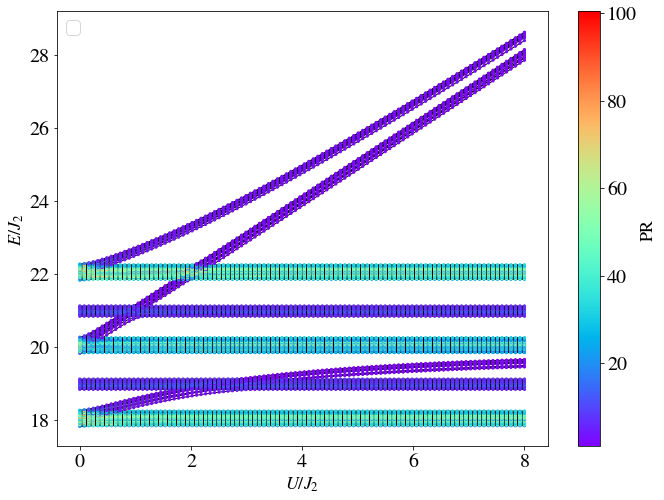

'plt.figure(figsize=[12,9])\nfor j in range(n_eigval):\n    plt.plot(U_array/J1, PRvsU[:, j], color=\'C\'+str(j), linewidth=2)\n#plt.scatter(U_array/J1, MaxEvsU, c=AvPRvsU, cmap=\'gist_rainbow\')\nplt.title("Participation ratio versus U Regular chain of N="+str(N)+" ω="+ str(ω)+ " J="+str(J1))\nplt.xscale(\'log\')\nplt.ylabel("PR")\nplt.xlabel("U/J")\nplt.savefig(\'PRvsU_SSH_\'+str(N)+\'_\'+ str(ω)+ \'_\'+str(J1)+\'.png\')\nplt.show()\nplt.show()\nplt.figure(figsize=[12,9])\nplt.plot(U_array/J1, AvPRvsU)\nplt.xlabel("U/J")\nplt.ylabel("<PR>")\nplt.show()'

In [115]:
n_eigval=int(N*(N+1)/2)
U_min=0
U_max=8*J_m
n_points=100
U_array=np.linspace(U_min, U_max, n_points)

Identity=np.identity(N)
base=np.empty((n_eigval, N))
counter=0
for l in range(N):
    for k in range(l,N):
        ketB=Identity[k,:]+Identity[l,:]
        #print(ketB)
        base[counter, :]=ketB
        counter+=1
"""Hprint=ComputeH(1,base, N)
print(Hprint)"""
MinPRvsUHyperMatrix = sweepUSubalg(U_min,U_max,n_points,base, N)
EvsU = np.empty((n_points, n_eigval))
PRvsU=np.empty((n_points, n_eigval))
eigvec=np.zeros((n_eigval, 2))
LocLength=np.zeros((n_points, 4))
errLocLength=np.zeros((n_points, 4))
for i in range(n_points):
    EvsU[i, :], PRvsU[i, :], eigvec[:, 0], eigvec[:, 1] = ComputeEigvalMinMax(MinPRvsUHyperMatrix[:,:,i])
    for j in range(2):
        LocLength[i, 2*j], errLocLength[i, 2*j],LocLength[i, 2*j+1], errLocLength[i, 2*j+1]=ComputeLocalizationLength(eigvec[:,j], base)
minPR=np.min(PRvsU)
maxPR=np.max(PRvsU)
min1PR=np.zeros(n_points, dtype='int')
min2PR=np.zeros(n_points, dtype='int')
min3PR=np.zeros(n_points, dtype='int')
for k in range(n_points):
    auxPRmin=np.argsort(PRvsU[k, :])
    min1PR[k]=auxPRmin[0]
    min2PR[k]=auxPRmin[1]
    min3PR[k]=auxPRmin[2]
plt.figure(figsize=[11,8])
for j in range(n_eigval):
    plt.plot(U_array/J2, EvsU[:, j]/J_m, color='black', zorder=0, linewidth=1)
    cmap1=mpl.cm.get_cmap('rainbow')
    plt.scatter(U_array/J2, EvsU[:, j]/J_m, c=PRvsU[:, j], cmap=cmap1, s=5)
    plt.clim(minPR, maxPR)
cb=plt.colorbar()
"""plt.scatter(U_array[0]/J2, EvsU[ 0, min1PR[0]]/J_m, facecolors='none', color='black', marker="^",s=40, label='Lowest PR')
plt.scatter(U_array[0]/J2, EvsU[ 0, min2PR[0]]/J_m, facecolors='none', color='black', marker="s",s=40, label='2nd lowest PR')
plt.scatter(U_array[0]/J2, EvsU[ 0, min3PR[0]]/J_m, facecolors='none', color='black', marker="o",s=40, label='3rd lowest PR')
for j in range(1, n_points):
    plt.scatter(U_array[j]/J2, EvsU[ j, min1PR[j]]/J_m, facecolors='none', color='black', marker="^", s=40)
    plt.scatter(U_array[j]/J2, EvsU[ j, min2PR[j]]/J_m, facecolors='none', color='black', marker="s", s=40)
    plt.scatter(U_array[j]/J2, EvsU[ j, min3PR[j]]/J_m, facecolors='none', color='black', marker="o", s=40)"""
#plt.scatter(U_array/J1, MaxEvsU, c=AvPRvsU, cmap='gist_rainbow'
#plt.title("Energy versus U SSH of N="+str(N)+" ω="+ str(ω)+ " J1="+str(J1)+ " J2="+str(J2))
cb.set_label(label='PR', size=18)
plt.ylabel("$E/J_2$", size=18)
plt.xlabel("$U/J_2$", size=18)
plt.legend(prop={'size':18})
plt.savefig('EvsU_SSH_'+str(N)+'_'+ str(ω)+ '_'+str(J1)+ '_'+str(J2)+'.png')
plt.show()

"""plt.figure(figsize=[12,9])
for j in range(n_eigval):
    plt.plot(U_array/J1, PRvsU[:, j], color='C'+str(j), linewidth=2)
#plt.scatter(U_array/J1, MaxEvsU, c=AvPRvsU, cmap='gist_rainbow')
plt.title("Participation ratio versus U Regular chain of N="+str(N)+" ω="+ str(ω)+ " J="+str(J1))
plt.xscale('log')
plt.ylabel("PR")
plt.xlabel("U/J")
plt.savefig('PRvsU_SSH_'+str(N)+'_'+ str(ω)+ '_'+str(J1)+'.png')
plt.show()
plt.show()
plt.figure(figsize=[12,9])
plt.plot(U_array/J1, AvPRvsU)
plt.xlabel("U/J")
plt.ylabel("<PR>")
plt.show()"""



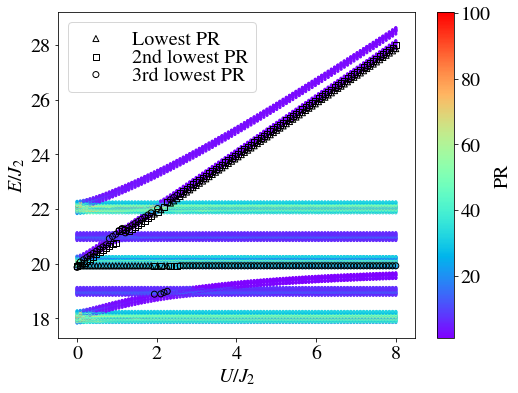

In [116]:
plt.figure(figsize=[8,6])
xpos=np.linspace(0, 8, 100)
xneg=np.linspace(-8, 0, 100)
#color=['blue', 'red', 'green']
for j in range(n_eigval):
    #plt.plot(U_array/J2, EvsU[:, j]/J_m, color='black', zorder=0, linewidth=1)
    cmap1=mpl.cm.get_cmap('rainbow')
    plt.scatter(U_array/J2, EvsU[:, j]/J_m, c=PRvsU[:, j], cmap=cmap1, s=5)
    #plt.scatter(U_array/J2, EvsU[:, j]/J_m, c=color[j], cmap=cmap1, s=45, label='Numerical energy '+str(j+1))
    plt.clim(minPR, maxPR)
#plt.plot(U_array/J2, (0.5*U_array-np.sqrt(0.25*U_array**2+4*J2**2))/J2, linewidth=3,zorder=0, color='black', label='Analytical expressions')
#plt.plot(U_array/J2, (0.5*U_array+np.sqrt(0.25*U_array**2+4*J2**2))/J2, linewidth=3,zorder=0, color='black')
#plt.plot(U_array/J2, U_array/J2, linewidth=3,zorder=0, color='black')

#plt.plot(U_array/J2, 0.5*U_array/J2+np.sqrt(0.25*U_array**2+4*J2**2)/J2, label='Dimer Energy Bands', color='black')
#plt.plot(U_array/J2, 0.5*U_array/J2-np.sqrt(0.25*U_array**2+4*J2**2)/J2, color='black')
#plt.plot(U_array/J2, U_array/J2, color='black')
#plt.hlines(0, -8, 8, alpha=0.5)
#plt.vlines(0, -10, 10, alpha=0.5)
#plt.vlines(5, -10, 10, color='red')
#plt.hlines(4, -8, 8, color='blue', linestyle='dashed', label='Scattering band')
#plt.hlines(-4, -8, 8, color='blue', linestyle='dashed')
#plt.xlim(0,6)
#plt.ylim(1.5, 11)
#EvsU-=ω
cb=plt.colorbar()
cb.set_label(label='PR')
plt.scatter(U_array[0]/J2, EvsU[ 0, min1PR[0]]/J_m, facecolors='none', color='black', marker="^", label='Lowest PR')
plt.scatter(U_array[0]/J2, EvsU[ 0, min2PR[0]]/J_m, facecolors='none', color='black', marker="s", label='2nd lowest PR')
plt.scatter(U_array[0]/J2, EvsU[ 0, min3PR[0]]/J_m, facecolors='none', color='black', marker="o", label='3rd lowest PR')
for j in range(1, n_points):
    plt.scatter(U_array[j]/J2, EvsU[ j, min1PR[j]]/J_m, facecolors='none', color='black', marker="^")
    plt.scatter(U_array[j]/J2, EvsU[ j, min2PR[j]]/J_m, facecolors='none', color='black', marker="s")
    plt.scatter(U_array[j]/J2, EvsU[ j, min3PR[j]]/J_m, facecolors='none', color='black', marker="o")
#plt.scatter(U_array/J1, MaxEvsU, c=AvPRvsU, cmap='gist_rainbow')
#plt.title("Energy versus U SSH of N="+str(N)+" ω="+ str(ω)+ " J1="+str(J1)+ " J2="+str(J2))
plt.ylabel("$E/J_2$")
plt.xlabel("$U/J_2$")
plt.legend(labelspacing=0)
plt.savefig('EvsU_SSH_'+str(N)+'_'+ str(ω)+ '_'+str(J1)+ '_'+str(J2)+'.png')
plt.show()

In [117]:
def funcSolveplus(U):
    return U+2-2*J1-2*np.sqrt(U**2/4+4*J2**2)
def funcSolveminus(U):
    return U+2+2*J1-2*np.sqrt(U**2/4+4*J2**2)

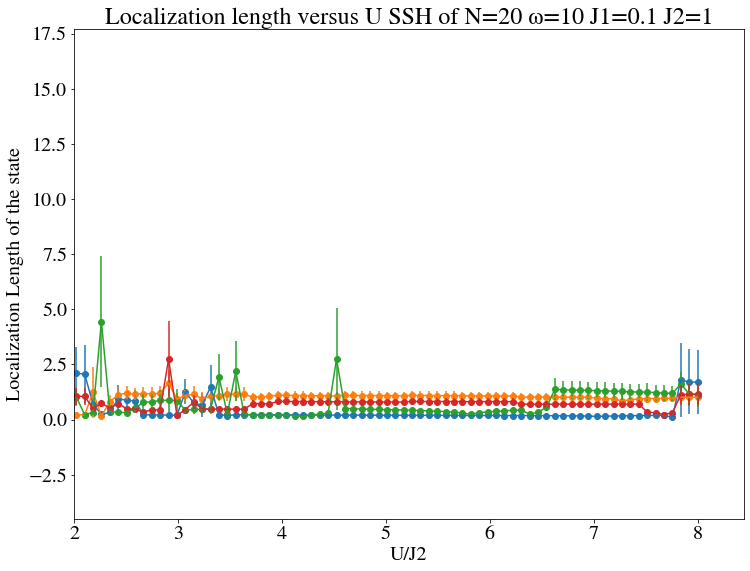

In [118]:
from scipy.optimize import fsolve
Umax=fsolve(funcSolveplus, x0=4)
Umin=fsolve(funcSolveminus, x0=3)
plt.figure(figsize=[12,9])
for j in range(4):
    plt.errorbar(U_array/J_m, np.abs(LocLength[:, j]), errLocLength[:, j])
    plt.scatter(U_array/J_m, np.abs(LocLength[:, j]))
#plt.axvspan(Umin/J_m, Umax/J_m, alpha=0.5)
plt.xlim(2,)
#plt.ylim(-5, 20)
plt.xlabel("U/J2")
plt.ylabel("Localization Length of the state")
plt.title("Localization length versus U SSH of N="+str(N)+" ω="+ str(ω)+ " J1="+str(J1)+ " J2="+str(J2))
plt.show()

In [119]:
print(np.argmax(LocLength))

27


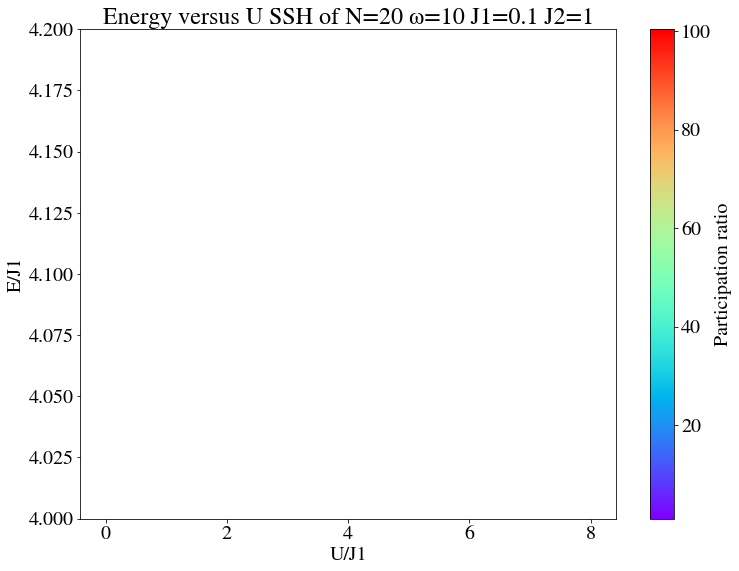

In [120]:
plt.figure(figsize=[12,9])
for j in range(n_eigval):
    #plt.plot(U_array/J2, EvsU[:, j]/J2, color='black', zorder=0, linewidth=1)
    cmap1=mpl.cm.get_cmap('rainbow')
    plt.scatter(U_array/J2, EvsU[:, j]/J2, c=PRvsU[:, j], cmap=cmap1, s=5)
    plt.clim(minPR, maxPR)
#plt.scatter(U_array/J1, MaxEvsU, c=AvPRvsU, cmap='gist_rainbow')
plt.colorbar(label='Participation ratio')
plt.title("Energy versus U SSH of N="+str(N)+" ω="+ str(ω)+ " J1="+str(J1)+ " J2="+str(J2))
plt.ylabel("E/J1")
plt.xlabel("U/J1")
plt.ylim(4, 4.2)
#plt.savefig('EvsU_SSH_'+str(N)+'_'+ str(ω)+ '_'+str(J1)+ '_'+str(J2)+'.png')
plt.show()

In [121]:
print(min1PR)

[ 88  73  72  72  71  71  71  71  71  71  71  71  71  71  71  71  71  71
  71  71  71  71  71  71 154  71 163  71  71 187 190 190 190 190 190 190
 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190
 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190
 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190 190
 190 190 190 190 190 190 190 190 190 190]
